In [40]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class BMP3DDataset(Dataset):
    def __init__(self, root_directory, transform=None):
        self.root_directory = root_directory
        self.transform = transform
        # Each subfolder is a sample
        self.sample_folders = sorted([
            os.path.join(root_directory, d)
            for d in os.listdir(root_directory)
            if os.path.isdir(os.path.join(root_directory, d))
        ])

    def __len__(self):
        return len(self.sample_folders)

    def __getitem__(self, idx):
        folder = self.sample_folders[idx]
        # Get all bmp files, sort numerically
        slice_files = sorted(
            [f for f in os.listdir(folder) if f.endswith('.bmp')],
            key=lambda x: int(os.path.splitext(x)[0])
        )
        slices = []
        for fname in slice_files:
            img_path = os.path.join(folder, fname)
            img = Image.open(img_path).convert('L')  # 'L' for grayscale
            img = np.array(img, dtype=np.float32) / 255.0  # normalize to [0,1]
            slices.append(img)
        volume = np.stack(slices, axis=0)  # shape: [depth, H, W]
        if self.transform:
            volume = self.transform(volume)
        # Add channel dimension: [1, depth, H, W] for PyTorch 3D conv
        volume = torch.from_numpy(volume).unsqueeze(0)
        return volume

def get_data_loader(directory, batch_size=4, shuffle=True, seed=42):
    dataset = BMP3DDataset(directory)
    generator = torch.Generator()
    generator.manual_seed(seed)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, generator=generator)

In [41]:
import os

# Go up two directories from src/utils to project root, then into data3d
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
data_directory = os.path.join(project_root, 'data3d')
print(data_directory)

/home/ptnguyen/Phu-Thien-Nguyen_LBM-PI-VAP-SinglePhaseFluidFLow/ptnguyen-pvae-3d-viscoelastic-open-foam/data3d


In [47]:
train_loader = get_data_loader(data_directory, batch_size=16, shuffle=True, seed=42)

In [38]:
for batch in train_loader:
    print("Batch shape:", batch.shape)
    print("Min value:", batch.min().item())
    print("Max value:", batch.max().item())
    break

Batch shape: torch.Size([16, 1, 200, 200, 200])
Min value: 0.0
Max value: 1.0


Sample shape: torch.Size([200, 200, 200])


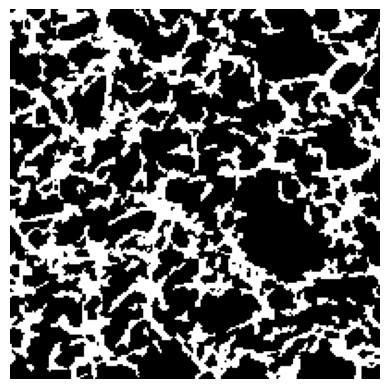

In [48]:
import matplotlib.pyplot as plt

for batch in train_loader:
    # batch shape: [batch_size, 1, depth, H, W]
    sample = batch[15, 0]  # shape: [depth, H, W]
    print("Sample shape:", sample.shape)
    # Show the middle slice
    mid_slice = sample.shape[0] // 2
    plt.imshow(sample[mid_slice].cpu().numpy(), cmap='gray')
    # plt.title(f"Slice {mid_slice}")
    plt.axis('off')
    plt.show()
    break